<a href="https://colab.research.google.com/github/chehansivaruban/Cyber---SDGP/blob/main/LSTM_final2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
df = pd.read_csv(
  "dateindex1.csv", 
  parse_dates=['datetime'], 
  index_col="datetime"
)
#index colum is set to the datetime 

In [10]:
df.shape

(105191, 1)

In [11]:
df.head()

,G
datetime,
2005-01-01 00:00:00,0.0
2005-01-01 01:00:00,55.0
2005-01-01 02:00:00,41.0
2005-01-01 03:00:00,203.0
2005-01-01 04:00:00,421.0


In [12]:
df.index

DatetimeIndex(['2005-01-01 00:00:00', '2005-01-01 01:00:00',
               '2005-01-01 02:00:00', '2005-01-01 03:00:00',
               '2005-01-01 04:00:00', '2005-01-01 05:00:00',
               '2005-01-01 06:00:00', '2005-01-01 07:00:00',
               '2005-01-01 08:00:00', '2005-01-01 09:00:00',
               ...
               '2016-12-31 13:00:00', '2016-12-31 14:00:00',
               '2016-12-31 15:00:00', '2016-12-31 16:00:00',
               '2016-12-31 17:00:00', '2016-12-31 18:00:00',
               '2016-12-31 19:00:00', '2016-12-31 20:00:00',
               '2016-12-31 21:00:00', '2016-12-31 22:00:00'],
              dtype='datetime64[ns]', name='datetime', length=105191, freq=None)

In [13]:
df.columns

Index(['G'], dtype='object')

In [14]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [15]:
df.head()

,G,hour,day_of_month,day_of_week,month
datetime,,,,,
2005-01-01 00:00:00,0.0,0,1,5,1
2005-01-01 01:00:00,55.0,1,1,5,1
2005-01-01 02:00:00,41.0,2,1,5,1
2005-01-01 03:00:00,203.0,3,1,5,1
2005-01-01 04:00:00,421.0,4,1,5,1


In [16]:
df.shape

(105191, 5)

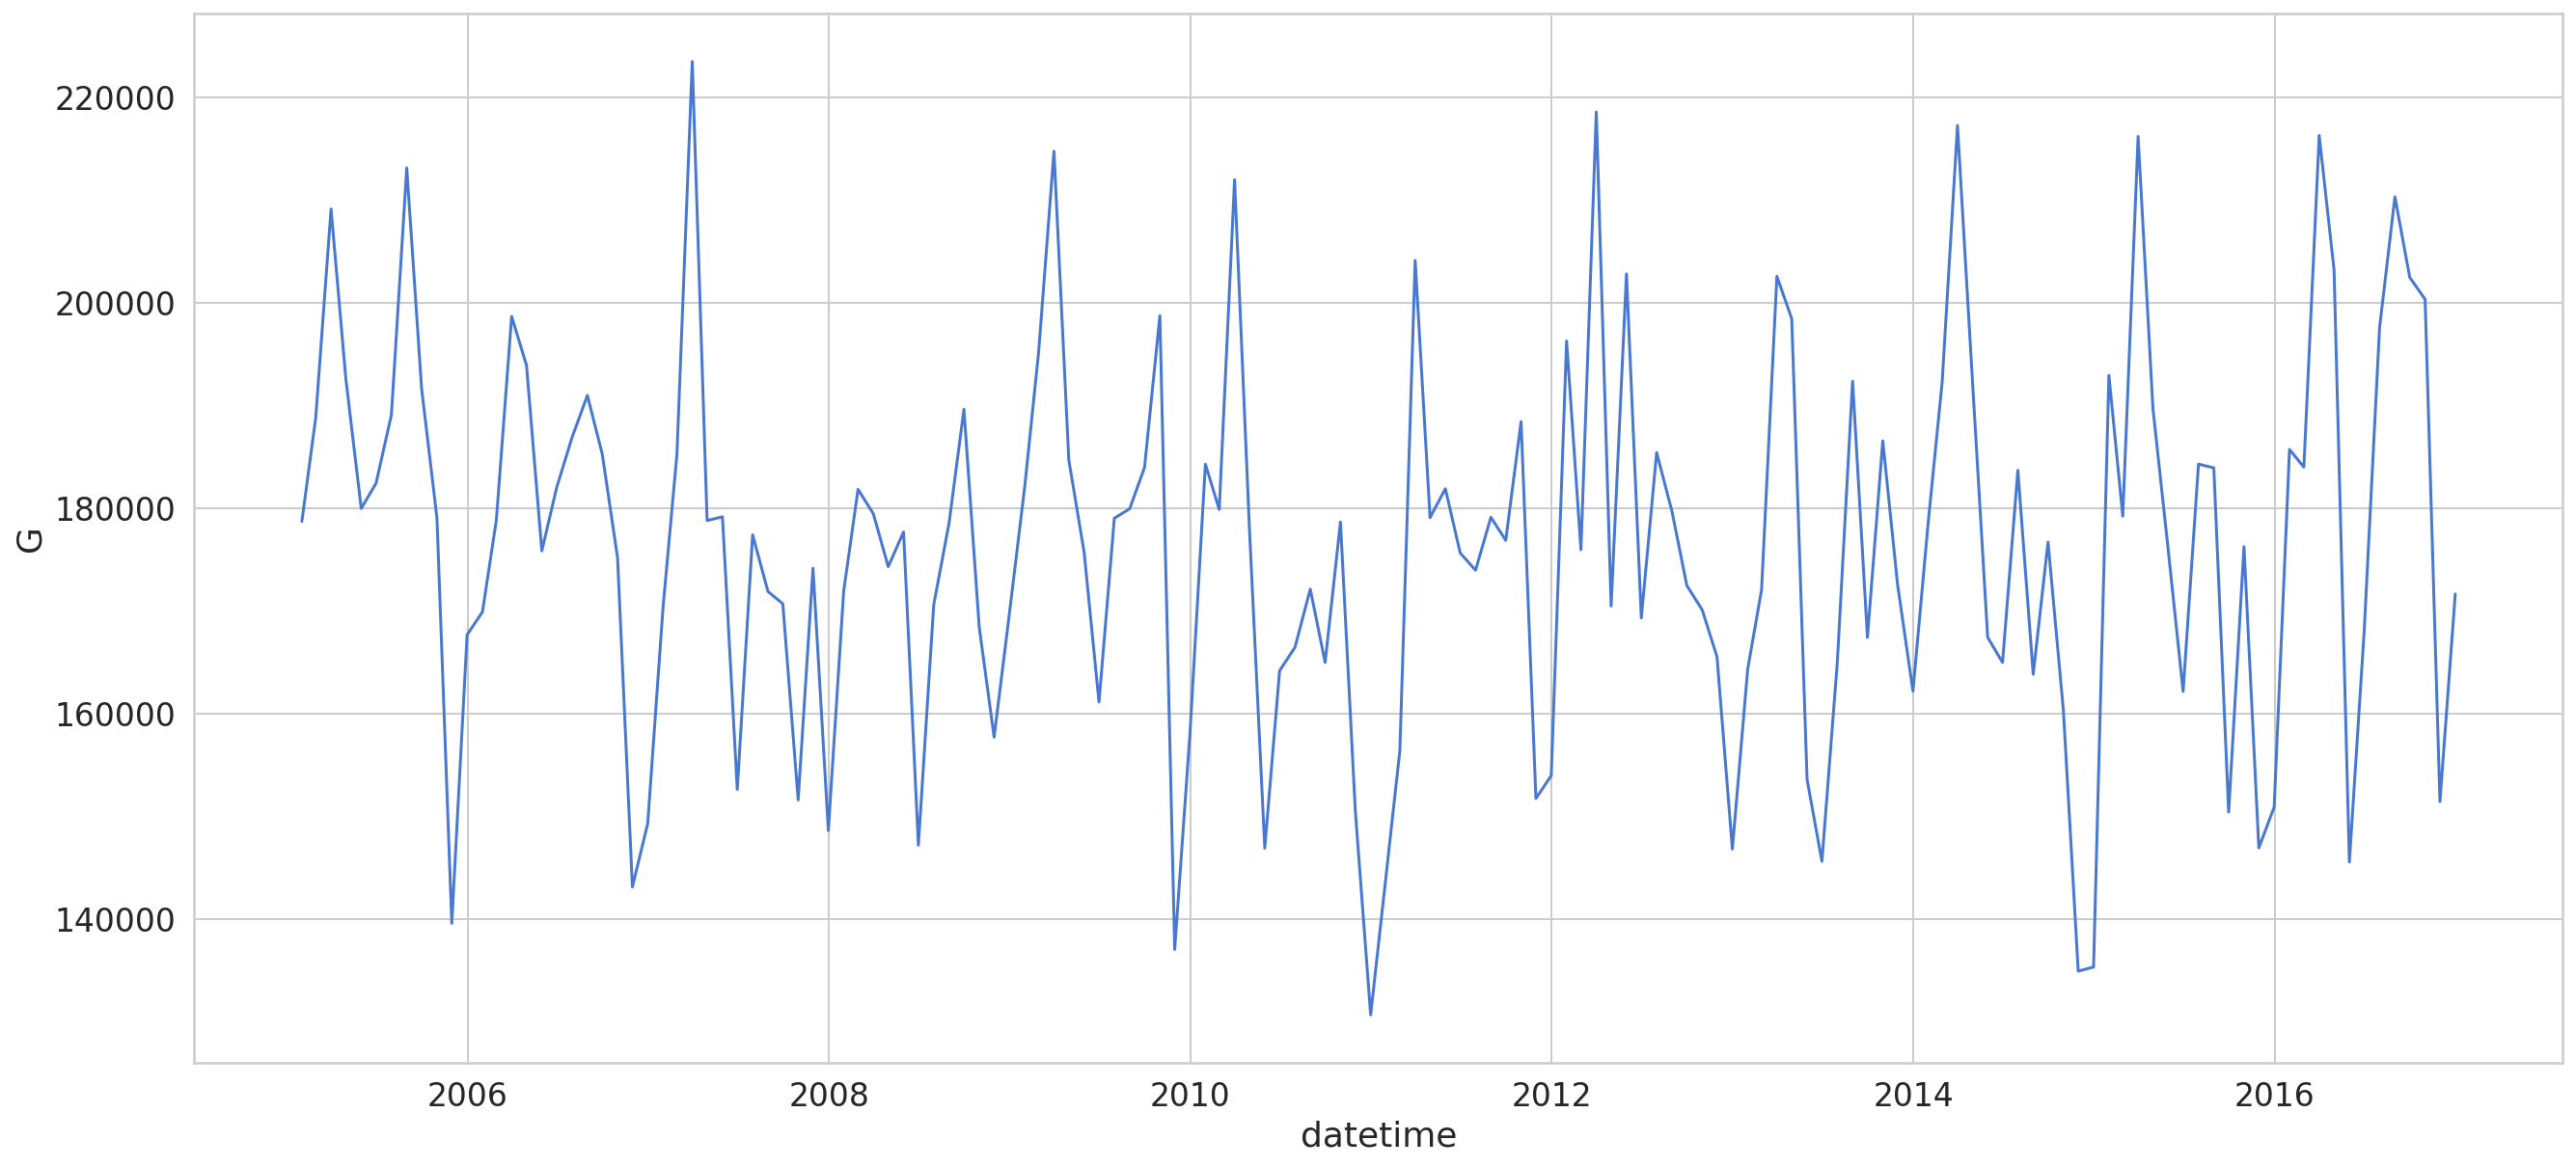

In [17]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="G", data=df_by_month);

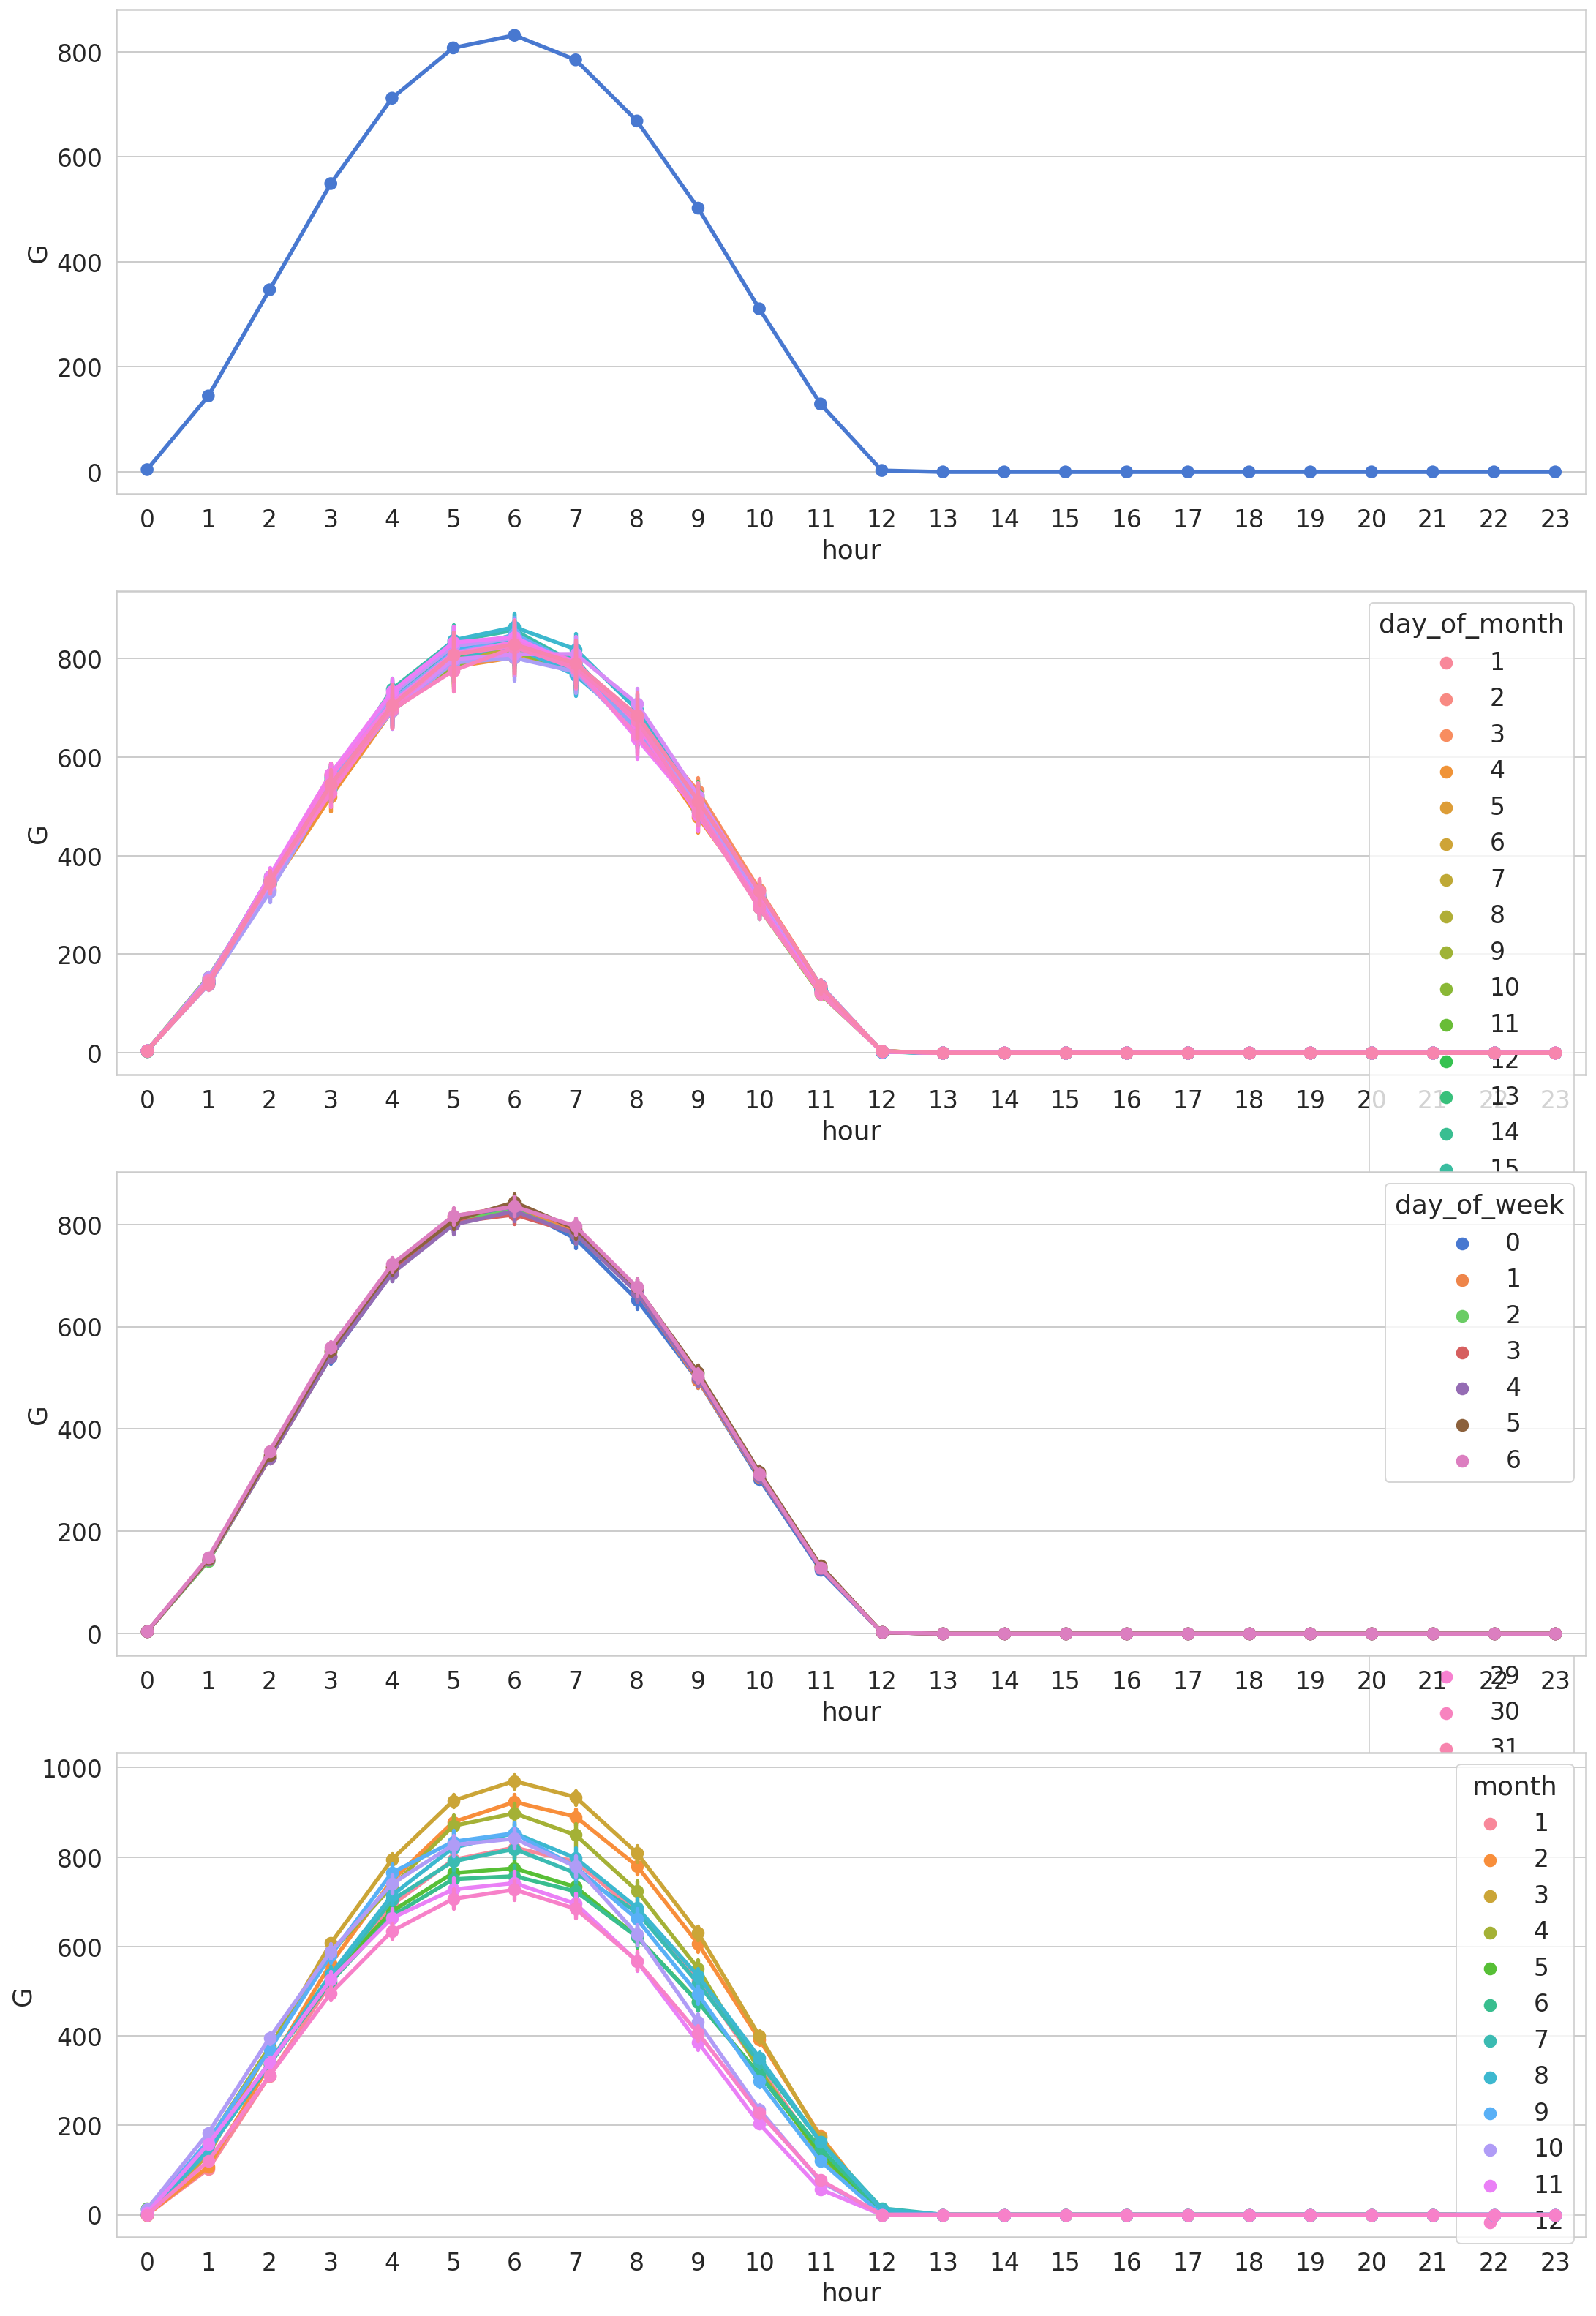

In [18]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='G', ax=ax1)
sns.pointplot(data=df, x='hour', y='G', hue='day_of_month', ax=ax2)
sns.pointplot(data=df, x='hour', y='G', hue='day_of_week', ax=ax3)
sns.pointplot(data=df, x='hour', y='G', hue='month', ax=ax4);

In [19]:
#divide trianing data and testing data 
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(73633, 5) (31558, 5)


In [20]:
#preprocessing the data to maximize efficiency
#scaling is done 

from sklearn.preprocessing import RobustScaler

f_columns = ['hour','day_of_month',	'day_of_week',	'month']

f_transformer = RobustScaler() # for the features
gi_transformer = RobustScaler() #G(i)


f_transformer = f_transformer.fit(train[f_columns].to_numpy())
gi_transformer = gi_transformer.fit(train[['G']])

train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['G'] = gi_transformer.transform(train[['G']])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['G'] = gi_transformer.transform(test[['G']])



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [21]:
test.shape

(31558, 5)

In [22]:
#cutting data to sub sequences
def create_dataset(x, y, time_steps=1): #timesteps is the history we want to use for our sequencs
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x.iloc[i:(i + time_steps)].to_numpy()
        xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(xs), np.array(ys)

In [23]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

x_train, y_train = create_dataset(train, train.G, time_steps)
x_test, y_test = create_dataset(test, test.G, time_steps)

print(x_train.shape, y_train.shape)

(73609, 24, 5) (73609,)


In [24]:
x_train[0][0]

array([ 0.        , -0.91666667, -1.        ,  0.5       , -0.83333333])

In [25]:
print(x_test.shape, y_test.shape)

(31534, 24, 5) (31534,)


In [26]:
x_test[0].shape

(24, 5)

In [27]:
x_test[0]

array([[ 0.44989339, -0.83333333,  0.73333333, -0.75      , -0.16666667],
       [ 0.99147122, -0.75      ,  0.73333333, -0.75      , -0.16666667],
       [ 1.42217484, -0.66666667,  0.73333333, -0.75      , -0.16666667],
       [ 1.65245203, -0.58333333,  0.73333333, -0.75      , -0.16666667],
       [ 1.95948827, -0.5       ,  0.73333333, -0.75      , -0.16666667],
       [ 2.0533049 , -0.41666667,  0.73333333, -0.75      , -0.16666667],
       [ 1.91471215, -0.33333333,  0.73333333, -0.75      , -0.16666667],
       [ 1.69296375, -0.25      ,  0.73333333, -0.75      , -0.16666667],
       [ 1.18763326, -0.16666667,  0.73333333, -0.75      , -0.16666667],
       [ 0.88486141, -0.08333333,  0.73333333, -0.75      , -0.16666667],
       [ 0.31130064,  0.        ,  0.73333333, -0.75      , -0.16666667],
       [ 0.        ,  0.08333333,  0.73333333, -0.75      , -0.16666667],
       [ 0.        ,  0.16666667,  0.73333333, -0.75      , -0.16666667],
       [ 0.        ,  0.25      ,  0.7

In [28]:
x_train[0]

array([[ 0.        , -0.91666667, -1.        ,  0.5       , -0.83333333],
       [ 0.11727079, -0.83333333, -1.        ,  0.5       , -0.83333333],
       [ 0.08742004, -0.75      , -1.        ,  0.5       , -0.83333333],
       [ 0.43283582, -0.66666667, -1.        ,  0.5       , -0.83333333],
       [ 0.89765458, -0.58333333, -1.        ,  0.5       , -0.83333333],
       [ 0.28784648, -0.5       , -1.        ,  0.5       , -0.83333333],
       [ 0.53304904, -0.41666667, -1.        ,  0.5       , -0.83333333],
       [ 0.85714286, -0.33333333, -1.        ,  0.5       , -0.83333333],
       [ 0.43283582, -0.25      , -1.        ,  0.5       , -0.83333333],
       [ 0.52452026, -0.16666667, -1.        ,  0.5       , -0.83333333],
       [ 0.46695096, -0.08333333, -1.        ,  0.5       , -0.83333333],
       [ 0.28571429,  0.        , -1.        ,  0.5       , -0.83333333],
       [ 0.        ,  0.08333333, -1.        ,  0.5       , -0.83333333],
       [ 0.        ,  0.16666667, -1. 

In [29]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(x_train.shape[1], x_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [88]:
history = model.fit(
    x_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2071/2071 [==============================] - 80s 37ms/step - loss: 0.0568 - val_loss: 0.0317
Epoch 2/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0264 - val_loss: 0.0305
Epoch 3/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0251 - val_loss: 0.0305
Epoch 4/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0245 - val_loss: 0.0305
Epoch 5/30
2071/2071 [==============================] - 74s 36ms/step - loss: 0.0242 - val_loss: 0.0298
Epoch 6/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0238 - val_loss: 0.0293
Epoch 7/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0237 - val_loss: 0.0290
Epoch 8/30
2071/2071 [==============================] - 76s 37ms/step - loss: 0.0235 - val_loss: 0.0286
Epoch 9/30
2071/2071 [==============================] - 75s 36ms/step - loss: 0.0233 - val_loss: 0.0284
Epoch 10/30
2071/2071 [==============================] - 75s 36m

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

NameError: ignored

In [40]:
y_pred = model.predict(x_test)

In [41]:
y_train_inv = gi_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = gi_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = gi_transformer.inverse_transform(y_pred)

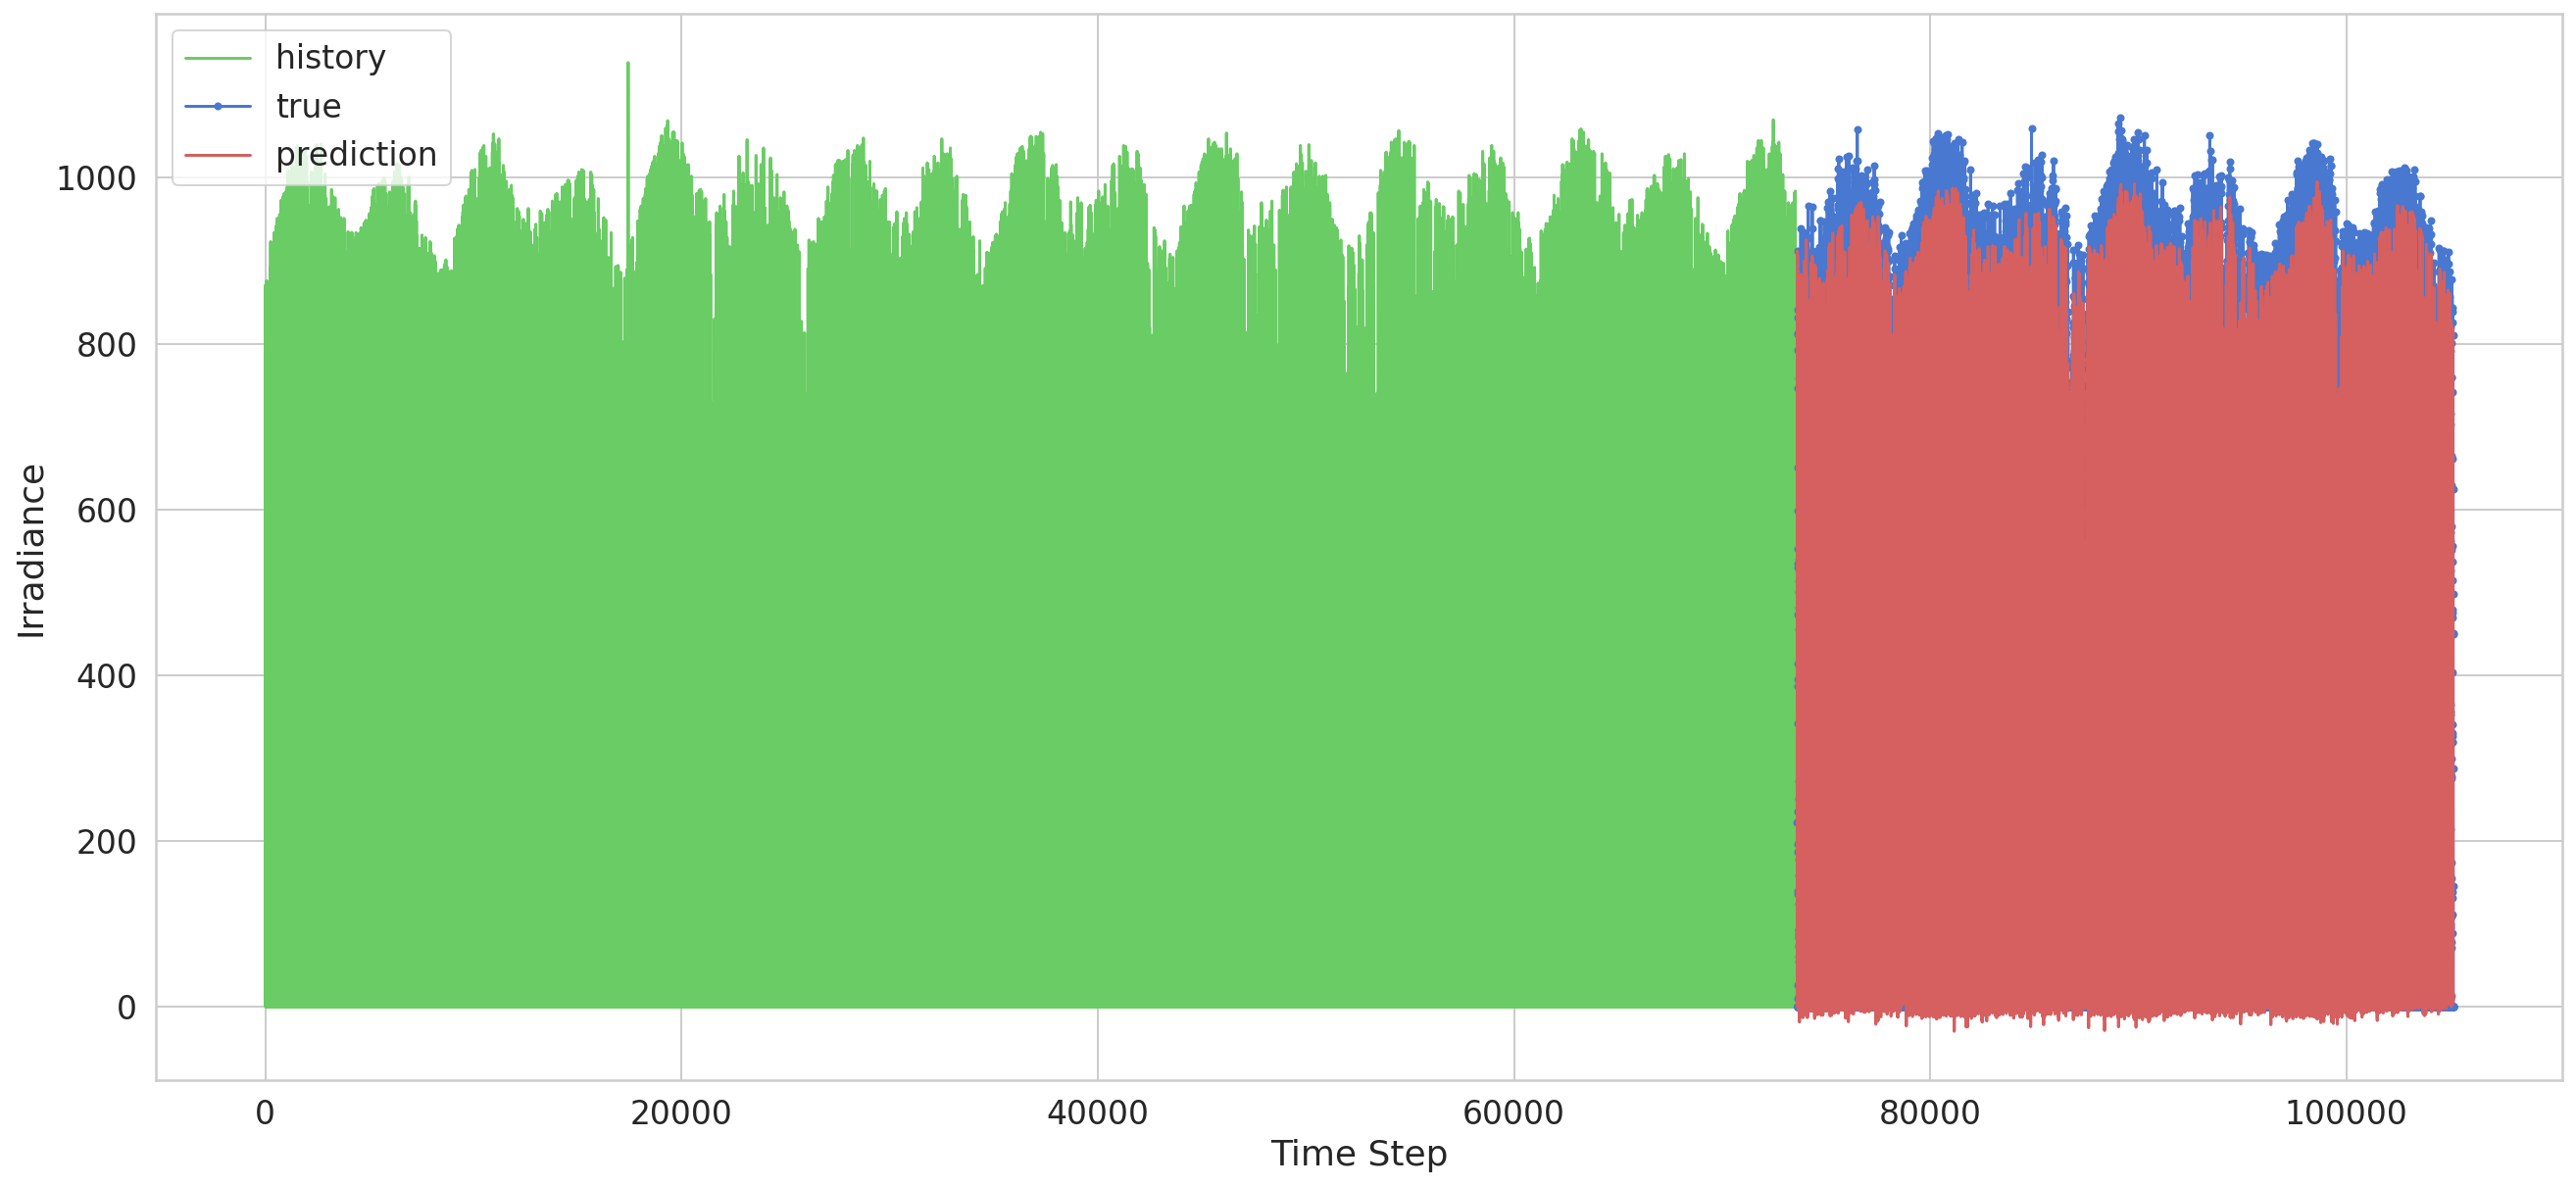

In [92]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();

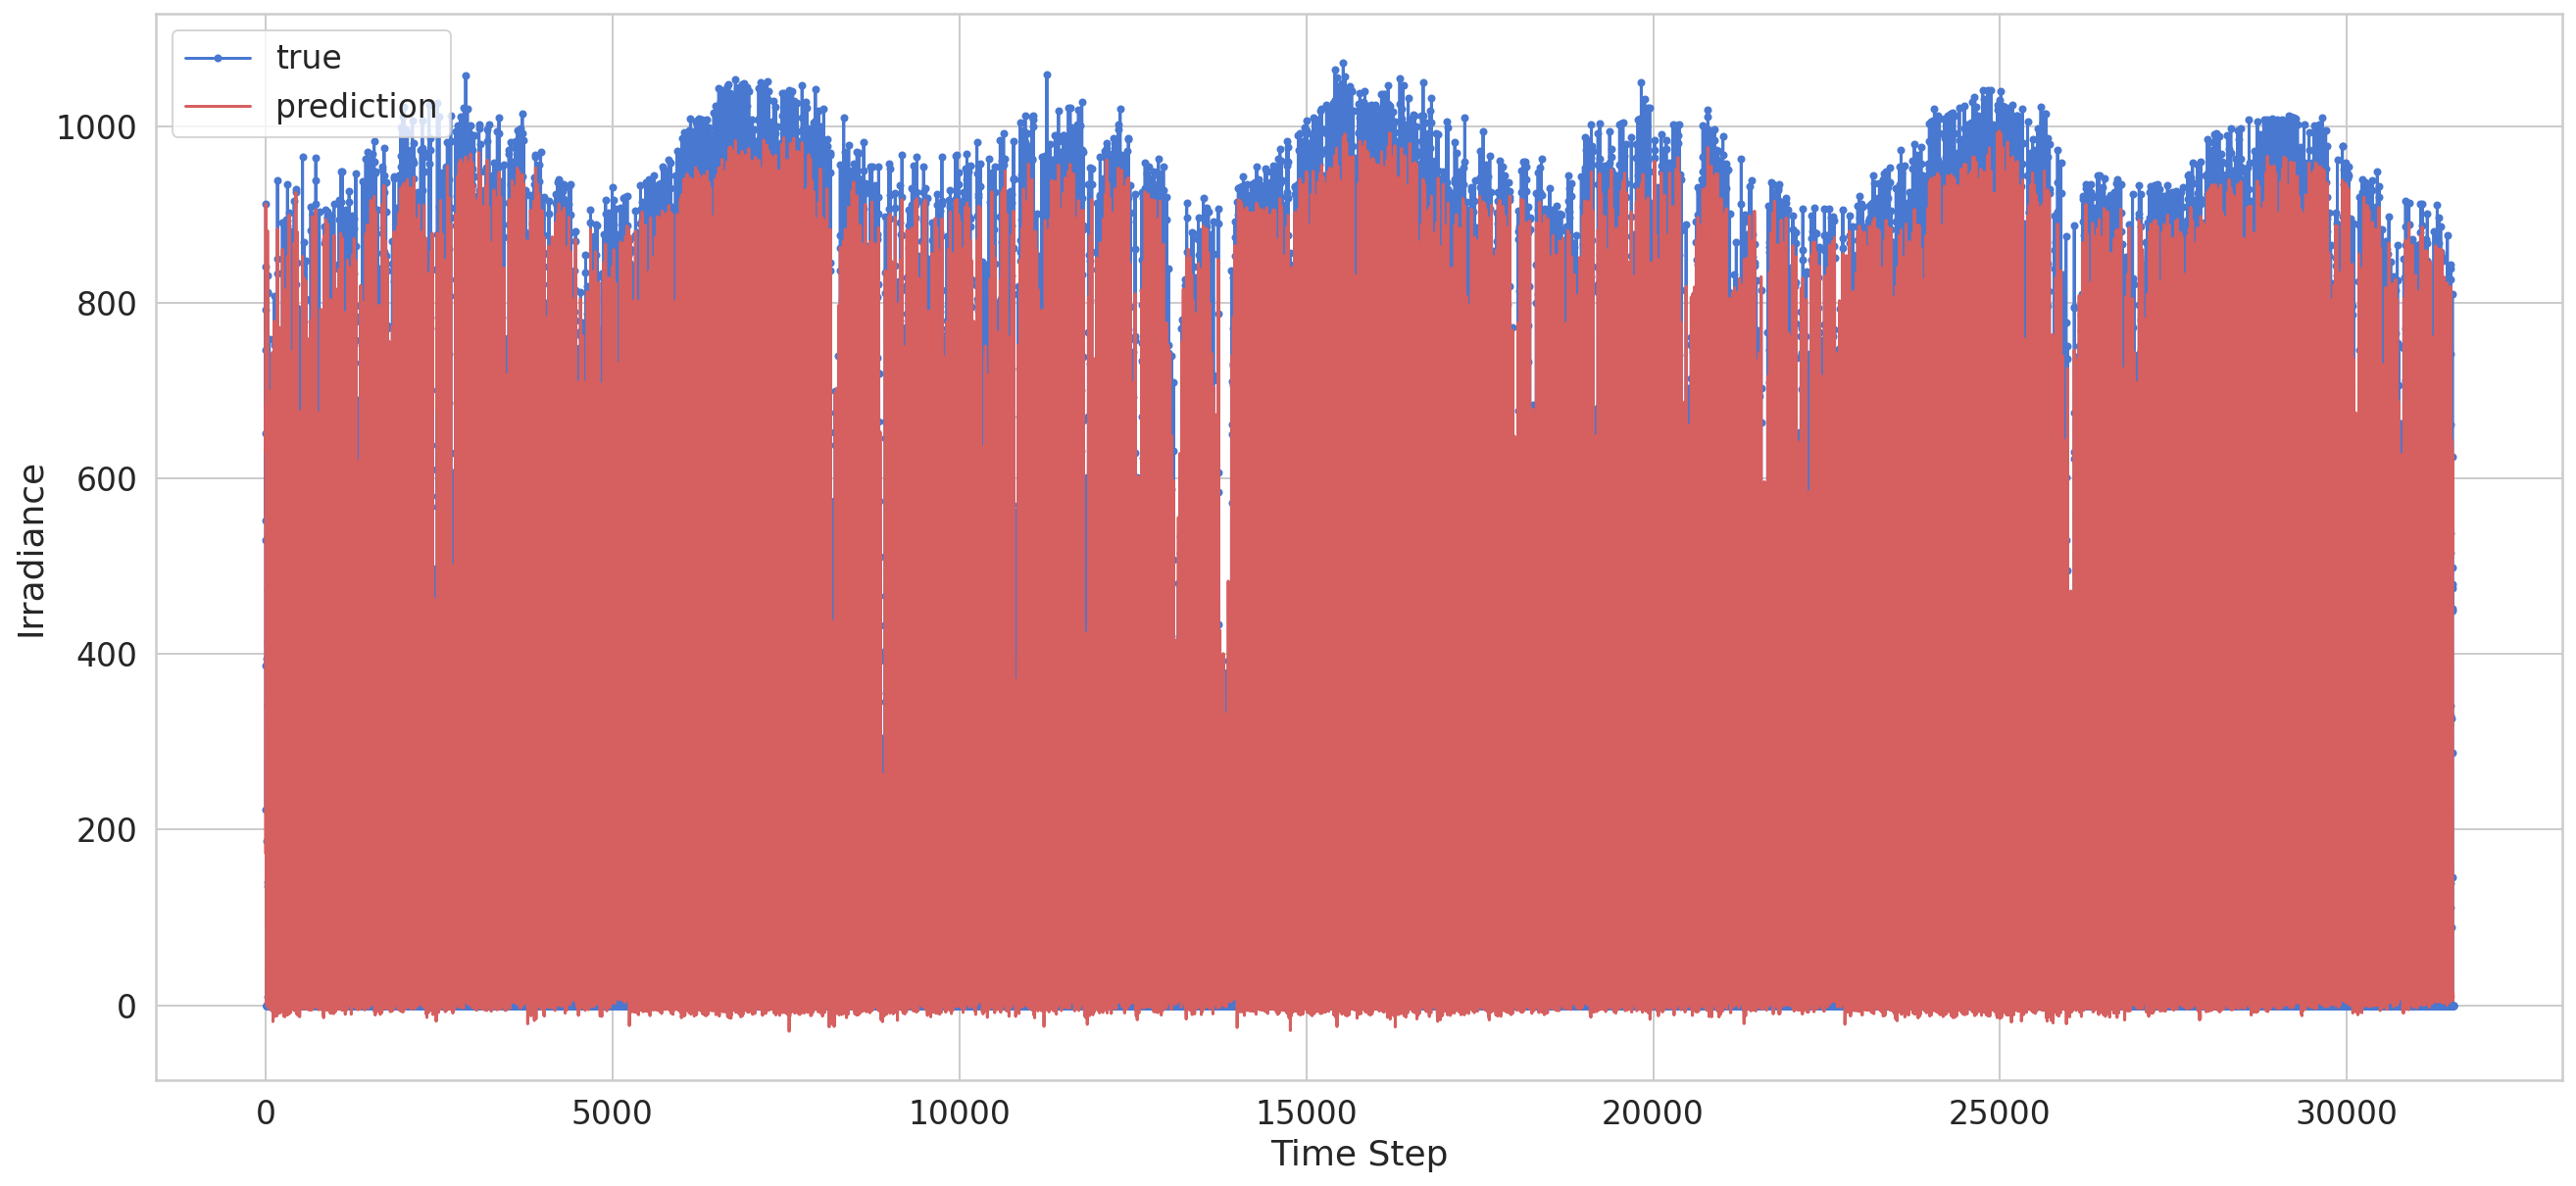

In [93]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [47]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               137216    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 137,473
Trainable params: 137,473
Non-trainable params: 0
_________________________________________________________________


In [48]:
y_pred = new_model.predict(x_test)

In [49]:
y_train_inv = gi_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = gi_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = gi_transformer.inverse_transform(y_pred)